In [2]:
# Importing the requisite libraries for this notebook
import re
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import train_test_split

import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

from scipy.sparse import hstack, vstack, csr_matrix
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

import shap
import matplotlib.pyplot as plt

# Download the VADER lexicon once (comment out after first run if you want)
nltk.download("vader_lexicon")

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/anthony/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [4]:
# 1. Load the Dataset

df = pd.read_csv("extremism_data_final.csv") 

# Keep track of original row index so we can retrieve later
df["row_id"] = df.index

In [5]:
# 2. Clean and Encode Labels

# Map EXTREMIST to 1, NON_EXTREMIST to 0
label_map = {
    "EXTREMIST": 1,
    "NON_EXTREMIST": 0,
}

# Lambda function to do the encoding
def encode_label(textData: str) -> int:
    return label_map[textData]

# Encoding
df["Binary_Label"] = df["Extremism_Label"].apply(encode_label)

# Checking the shape
print(df.shape)

# Our final labels
y = df["Binary_Label"].values.astype(np.int64)

(2776, 4)


In [25]:
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack, vstack, csr_matrix
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# -------------------------------------------------------------------
# 1. Fit TF-IDF on the whole corpus (up to 4996 features)
# -------------------------------------------------------------------
MAX_TOTAL_FEATURES = 20000
N_VADER_FEATURES = 4
MAX_TFIDF_FEATURES = MAX_TOTAL_FEATURES - N_VADER_FEATURES  # 4996

texts = df["Original_Message"].fillna("").astype(str).tolist()

tfidf_vectorizer = TfidfVectorizer(
    max_features=MAX_TFIDF_FEATURES,
    min_df = 3,
    ngram_range = (1, 3)
)
tfidf_vectorizer.fit(texts)

# VADER analyzer (we'll reuse this in the function)
analyzer = SentimentIntensityAnalyzer()


# -------------------------------------------------------------------
# 2. Define the vectorizer FUNCTION: string -> feature vector
# -------------------------------------------------------------------
def vectorize_text(text: str):
    """
    Take a single text string and return a feature vector:
      [TF-IDF features | VADER neg, neu, pos, compound]

    Output shape: (1, n_features) as a sparse CSR matrix.
    """

    # --- TF-IDF part (1 x <=4996) ---
    X_tfidf = tfidf_vectorizer.transform([text])  # list of one doc

    # --- VADER part (1 x 4) ---
    scores = analyzer.polarity_scores(text)
    vader_vec = np.array([[scores["neg"], scores["neu"], scores["pos"], scores["compound"]]])
    X_vader = csr_matrix(vader_vec)

    # --- Concatenate horizontally: [TF-IDF | VADER] ---
    X_full = hstack([X_tfidf, X_vader], format="csr")

    return X_full  # shape: (1, n_features)


# -------------------------------------------------------------------
# 3. Apply vectorize_text() to EACH item in Original_Message
# -------------------------------------------------------------------
row_vectors = [
    vectorize_text(t) for t in df["Original_Message"].fillna("").astype(str)
]

# Stack all 1-row matrices into a big feature matrix
X = vstack(row_vectors)   # shape: (n_samples, n_features)

print("Feature matrix shape:", X.shape)  # e.g. (2776, 6874)

# -------------------------------------------------------------------
# 4. Build human-readable feature_names for SHAP
#    [ TF-IDF tokens | VADER scores ]
# -------------------------------------------------------------------

# TF-IDF feature names (one per TF-IDF column)
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
print("Number of TF-IDF features:", len(tfidf_feature_names))

# VADER feature names (these are always the last 4 columns)
vader_feature_names = ["vader_neg", "vader_neu", "vader_pos", "vader_compound"]

# Full feature_names list must match the number of columns in X
feature_names = list(tfidf_feature_names) + vader_feature_names

print("Total features in feature_names:", len(feature_names))
assert len(feature_names) == X.shape[1], "feature_names length must match X.shape[1]"

Feature matrix shape: (2776, 6874)
Number of TF-IDF features: 6870
Total features in feature_names: 6874


In [7]:
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import torch

# X: scipy.sparse matrix of shape (N, 5000)
# y: numpy array of shape (N,)

# 1) Convert X and y to dense NumPy arrays
X_np = X.toarray().astype(np.float32)           # shape: (N, 5000)
y_np = y.astype(np.float32).reshape(-1, 1)      # shape: (N, 1)

# 2) Train/validation split (80% train, 20% val)
X_train_np, X_val_np, y_train_np, y_val_np = train_test_split(
    X_np,
    y_np,
    test_size=0.2,               # 20% validation
    random_state=30,
    stratify=y_np.reshape(-1),   # keep class balance
)

# 3) Convert splits to PyTorch tensors
X_train = torch.from_numpy(X_train_np)   # (N_train, 5000)
y_train = torch.from_numpy(y_train_np)   # (N_train, 1)

X_val   = torch.from_numpy(X_val_np)     # (N_val, 5000)
y_val   = torch.from_numpy(y_val_np)     # (N_val, 1)

# 4) Build DataLoader for training set (mini-batches)
train_ds = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)

# 5) Print shapes for sanity check
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:  ", X_val.shape)
print("y_val shape:  ", y_val.shape)

X_train shape: torch.Size([2220, 6874])
y_train shape: torch.Size([2220, 1])
X_val shape:   torch.Size([556, 6874])
y_val shape:   torch.Size([556, 1])


In [8]:
class SingleLayerNet(nn.Module):
    def __init__(self, input_size, hidden_neurons, output_size):
        super(SingleLayerNet, self).__init__()
        # Hidden layer: input_size -> hidden_neurons
        self.hidden_layer = nn.Linear(input_size, hidden_neurons)
        # Output layer: hidden_neurons -> output_size
        self.output_layer = nn.Linear(hidden_neurons, output_size)
        
    def forward(self, x):
        # Hidden layer + sigmoid
        hidden_output = torch.sigmoid(self.hidden_layer(x))
        # Output layer + sigmoid → predicted probability in (0,1)
        y_pred = torch.sigmoid(self.output_layer(hidden_output))
        return y_pred

In [9]:
input_size = X_train.shape[1]   # 5000 features
hidden_neurons = 512             # you can tune this (8, 16, 32, ...)
output_size = 1                  # binary classification

model2 = SingleLayerNet(input_size, hidden_neurons, output_size)
print(model2)

SingleLayerNet(
  (hidden_layer): Linear(in_features=6874, out_features=512, bias=True)
  (output_layer): Linear(in_features=512, out_features=1, bias=True)
)


In [11]:
def criterion(y_pred, y_true):
    # y_pred: (batch_size, 1), probabilities in (0,1)
    # y_true: (batch_size, 1), 0 or 1
    eps = 1e-8  # to avoid log(0)
    loss = -1 * (y_true * torch.log(y_pred + eps) + (1 - y_true) * torch.log(1 - y_pred + eps))
    mean_loss = torch.mean(loss)
    return mean_loss

optimizer = optim.SGD(model2.parameters(), lr=0.1)

In [15]:
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix  # <--- NEW

epochs = 1  # can increase later
train_losses = []
val_losses = []
val_accuracies = []
best_val_acc = 0.0
best_epoch = None
best_state_dict = None

for epoch in range(epochs):
    # ===== TRAINING PHASE =====
    model2.train()
    total_train_loss = 0.0
    total_train_examples = 0

    for xb, yb in train_loader:
        # xb: (batch_size, 5000)
        # yb: (batch_size, 1)

        # Forward pass
        y_pred = model2(xb)              # (batch_size, 1)

        # Loss
        loss = criterion(y_pred, yb)

        # Backprop + update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track loss weighted by batch size
        batch_size = xb.size(0)
        total_train_loss += loss.item() * batch_size
        total_train_examples += batch_size

    avg_train_loss = total_train_loss / total_train_examples
    train_losses.append(avg_train_loss)

    # ===== VALIDATION PHASE =====
    model2.eval()
    with torch.no_grad():
        # Forward on full validation set
        y_val_pred = model2(X_val)                # (N_val, 1)
        val_loss = criterion(y_val_pred, y_val).item()
        val_losses.append(val_loss)

        # Convert probabilities to 0/1 labels
        y_val_pred_labels = (y_val_pred >= 0.5).float()
        correct = (y_val_pred_labels == y_val).sum().item()
        total = y_val.shape[0]
        val_acc = correct / total
        val_accuracies.append(val_acc)
        
    # after computing val_acc:
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_epoch = epoch + 1
        best_state_dict = model2.state_dict()

    print(
        f"Epoch {epoch+1}/{epochs} - "
        f"train loss: {avg_train_loss:.4f} - "
        f"val loss: {val_loss:.4f} - "
        f"val acc: {val_acc:.4f}"
    )

print(f"\nFinal validation accuracy: {val_accuracies[-1]:.4f}")
print("Best val acc:", best_val_acc, "at epoch", best_epoch)

# Load best model before computing sklearn metrics
model2.load_state_dict(best_state_dict)

# ===== SKLEARN-STYLE METRICS ON BEST MODEL =====
model2.eval()
with torch.no_grad():
    # predicted probabilities on full val set
    y_val_pred = model2(X_val).cpu().numpy().ravel()

# true labels as 1D numpy array
y_val_true = y_val.cpu().numpy().ravel()

# threshold probabilities at 0.5
y_val_pred_labels = (y_val_pred >= 0.5).astype(int)
y_val_true_int = y_val_true.astype(int)

acc = accuracy_score(y_val_true_int, y_val_pred_labels)
f1_macro = f1_score(y_val_true_int, y_val_pred_labels, average="macro")
f1_weighted = f1_score(y_val_true_int, y_val_pred_labels, average="weighted")

print("\nSklearn metrics on validation set (Perceptron model):")
print(f"Accuracy:         {acc:.4f}")
print(f"F1 (macro):       {f1_macro:.4f}")
print(f"F1 (weighted):    {f1_weighted:.4f}\n")

print("Classification report:")
print(classification_report(y_val_true_int, y_val_pred_labels))

print("Confusion matrix:")
print(confusion_matrix(y_val_true_int, y_val_pred_labels))

Epoch 1/1 - train loss: 0.0578 - val loss: 0.4242 - val acc: 0.8237

Final validation accuracy: 0.8237
Best val acc: 0.8237410071942446 at epoch 1

Sklearn metrics on validation set (Perceptron model):
Accuracy:         0.8237
F1 (macro):       0.8237
F1 (weighted):    0.8238

Classification report:
              precision    recall  f1-score   support

           0       0.86      0.80      0.83       291
           1       0.79      0.85      0.82       265

    accuracy                           0.82       556
   macro avg       0.82      0.83      0.82       556
weighted avg       0.83      0.82      0.82       556

Confusion matrix:
[[232  59]
 [ 39 226]]


In [16]:
# 9. SHAP setup: explainer for model2

shap.initjs()
model2.eval()

def model2_predict(x_np):
    with torch.no_grad():
        x_tensor = torch.from_numpy(x_np.astype(np.float32))
        probs = model2(x_tensor).cpu().numpy().ravel()
    return probs

# Summarize the background with K representative samples (faster SHAP)
K = 50  # you can try 20, 50, 100 depending on speed/accuracy tradeoff
background = shap.kmeans(X_train_np, K)

# Build the SHAP KernelExplainer
explainer = shap.KernelExplainer(model2_predict, background)

In [18]:
# 10. Compute SHAP values for a subset of the validation set

# To keep SHAP reasonably fast, explain only up to 100 validation examples
explain_size = min(99, X_val_np.shape[0])
X_val_explain = X_val_np[:explain_size]

# Compute SHAP values (this might take a bit)
shap_values = explainer.shap_values(X_val_explain)

# If shap_values is a list (e.g., some configs return [array])
if isinstance(shap_values, list):
    shap_values = shap_values[0]

shap_values = np.array(shap_values)

print("X_val_explain shape:", X_val_explain.shape)
print("SHAP values shape:   ", shap_values.shape)

  0%|          | 0/99 [00:00<?, ?it/s]

X_val_explain shape: (99, 6874)
SHAP values shape:    (99, 6874)


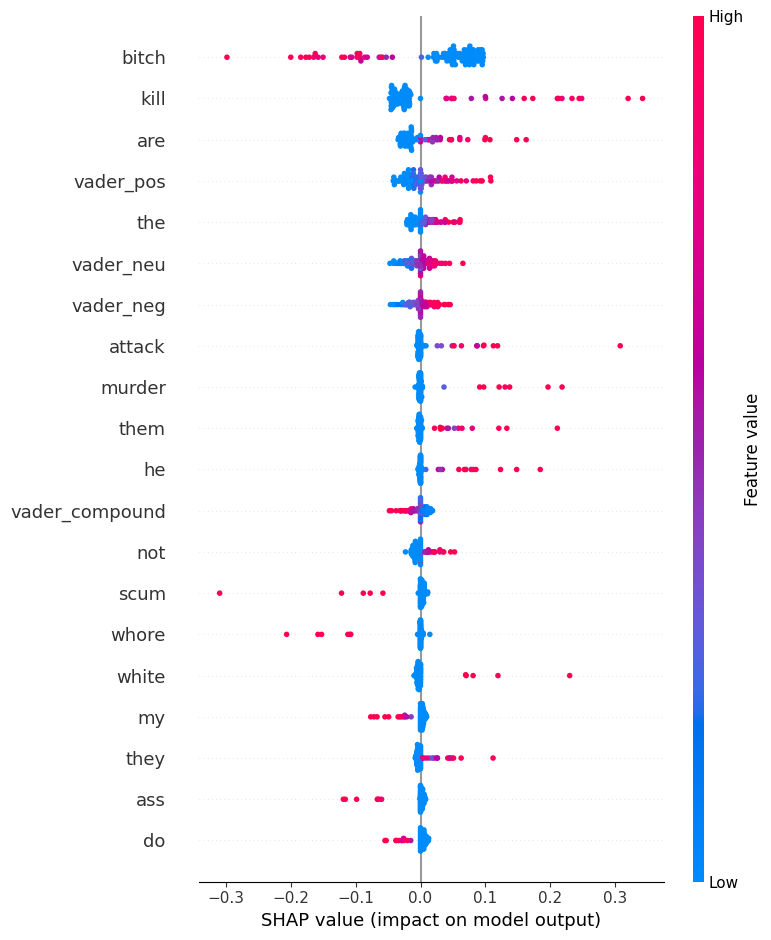

In [26]:
# 11. Global SHAP summary (beeswarm plot)

# Safety: if feature_names doesn't exist for some reason, create it
try:
    feature_names
except NameError:
    feature_names = [f"feature_{i}" for i in range(X_val_explain.shape[1])]

shap.summary_plot(
    shap_values,
    X_val_explain,
    feature_names=feature_names,
    show=True
)

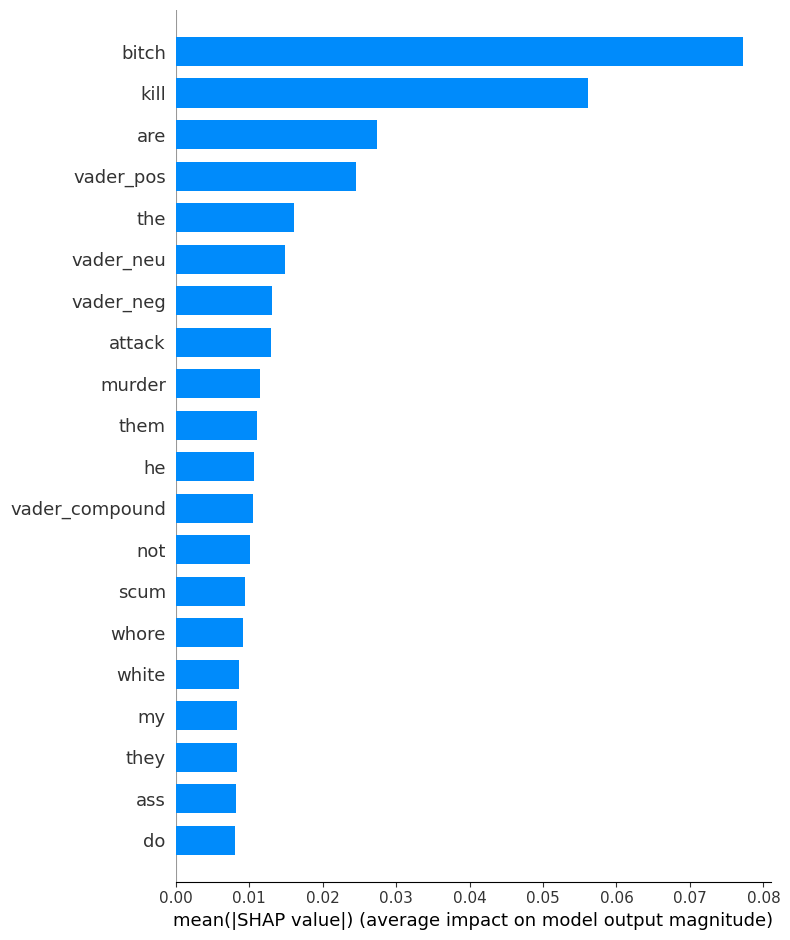

In [27]:
# 12. Mean absolute SHAP values (bar plot)

shap.summary_plot(
    shap_values,
    X_val_explain,
    feature_names=feature_names,
    plot_type="bar",
    show=True
)

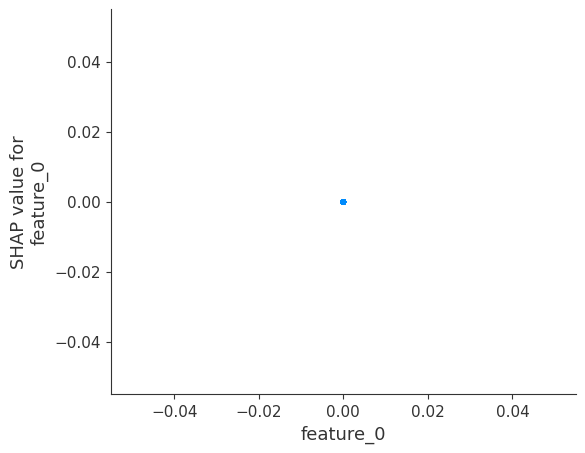

In [22]:
# 13. SHAP dependence plot for a single feature

# Choose which feature to inspect by index (0-based).
# After looking at the bar plot, set this to the index of a top feature.
feature_idx = 0  # change this after seeing which feature is most important

shap.dependence_plot(
    feature_idx,
    shap_values,
    X_val_explain,
    feature_names=feature_names
)

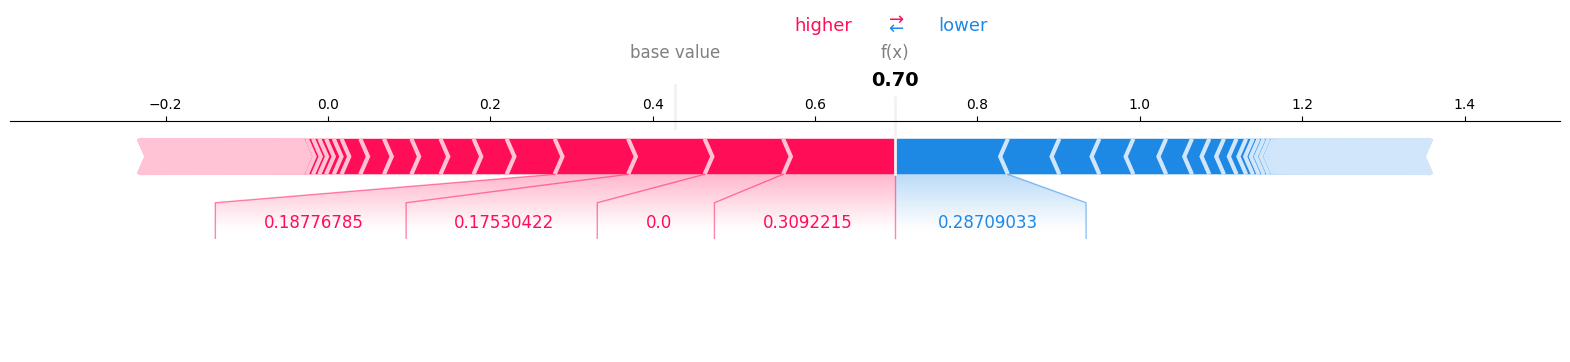

In [28]:
# 14. SHAP explanation for a single prediction

# Pick which explained example to look at (0 <= i < explain_size)
i = 0

# Interactive JS force plot (might not render in all environments)
shap.force_plot(
    explainer.expected_value,
    shap_values[i, :],
    X_val_explain[i, :],
    matplotlib=False
)

# Static matplotlib version (works reliably in VS Code / Jupyter)
shap.force_plot(
    explainer.expected_value,
    shap_values[i, :],
    X_val_explain[i, :],
    matplotlib=True
)

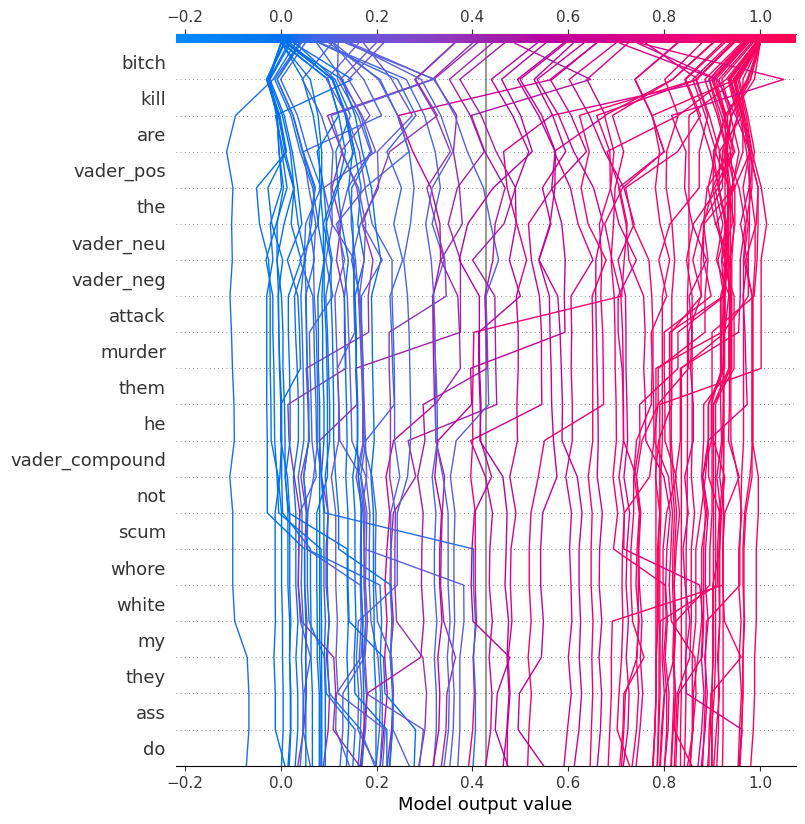

In [29]:
# 15. SHAP decision plot (optional)

shap.decision_plot(
    explainer.expected_value,
    shap_values,
    feature_names=feature_names,
)

In [33]:
# 9. Use the trained model to score *all* rows and find disagreements

model2.eval()

with torch.no_grad():
    # X_np is the full feature matrix from Cell 4
    X_all_tensor = torch.from_numpy(X_np)  # shape: (N, num_features)
    # Model outputs probabilities for the "1" (EXTREMIST) class
    y_all_probs = model2(X_all_tensor).cpu().numpy().ravel()

# True labels for all rows (0/1)
y_all_true = y_np.ravel().astype(int)

# Predicted labels from the model
y_all_pred = (y_all_probs >= 0.5).astype(int)

# Store predictions & probabilities in the DataFrame for inspection
df["model_prob_extremist"] = y_all_probs
df["model_pred_label"] = y_all_pred

# Where does the model disagree with the dataset label?
disagree_mask = (y_all_true != y_all_pred)
print("Number of disagreements between model and gold label:", disagree_mask.sum())

df_disagree = df.loc[disagree_mask].copy()
df_disagree["true_label"] = y_all_true[disagree_mask]
df_disagree["pred_label"] = y_all_pred[disagree_mask]

# How confident was the model in these disagreeing predictions?
df_disagree["model_confidence"] = np.where(
    df_disagree["model_prob_extremist"] >= 0.5,
    df_disagree["model_prob_extremist"],
    1.0 - df_disagree["model_prob_extremist"],
)

# Sort most suspicious first (high-confidence disagreements)
df_disagree = df_disagree.sort_values("model_confidence", ascending=False)

# Look at top 20 most suspicious examples
df_disagree[[
    "row_id",               # original dataset index
    "Original_Message",
    "Extremism_Label",
    "true_label",
    "pred_label",
    "model_prob_extremist",
    "model_confidence",
]]

Number of disagreements between model and gold label: 101


,row_id,Original_Message,Extremism_Label,true_label,pred_label,model_prob_extremist,model_confidence
1586,1586,qanon cult canons q army thegreatawakening tru...,EXTREMIST,1,0,0.000128,0.999872
39,39,i hate being muslim in a city where everyone t...,NON_EXTREMIST,0,1,0.997551,0.997551
213,213,here whatever go again a population of trapped...,NON_EXTREMIST,0,1,0.997533,0.997533
353,353,western media just ignores muslims for the mos...,NON_EXTREMIST,0,1,0.997495,0.997495
724,724,retweet you hang out with a hoe you re going t...,EXTREMIST,1,0,0.003362,0.996638
...,...,...,...,...,...,...,...
1589,1589,bycottzomato halal and halal are two most crue...,EXTREMIST,1,0,0.468891,0.531109
180,180,stop allowing illegals to dump their kids at t...,EXTREMIST,1,0,0.470677,0.529323
156,156,breaking after a week long trial a line county...,NON_EXTREMIST,0,1,0.527812,0.527812
1167,1167,one of the world s most prominent jihad forums...,NON_EXTREMIST,0,1,0.515960,0.515960


In [34]:
# 10. Save candidate mislabels for manual review

df_disagree.to_csv("potential_mislabels_by_model.csv", index=False)
print("Saved", len(df_disagree), "rows to potential_mislabels_by_model.csv")

# If you also made df_suspicious (high-confidence subset), you can save that too:
# df_suspicious.to_csv("high_conf_potential_mislabels.csv", index=False)
# print("Saved", len(df_suspicious), "rows to high_conf_potential_mislabels.csv")

Saved 101 rows to potential_mislabels_by_model.csv
